In [1]:
import tensorflow as tf
import numpy as np
import math
import os
import random
import numpy as np
import pandas as pd
from pandas import DataFrame
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle
import copy
import matplotlib.pyplot as plt

In [3]:
state_features = ['MIMICzs1','MIMICzs2','MIMICzs3','MIMICzs4','MIMICzs5','MIMICzs6','MIMICzs7','MIMICzs8','MIMICzs9','MIMICzs10','MIMICzs11','MIMICzs12','MIMICzs13','MIMICzs14','MIMICzs15','MIMICzs16','MIMICzs17','MIMICzs18','MIMICzs19','MIMICzs20','MIMICzs21','MIMICzs22','MIMICzs23','MIMICzs24','MIMICzs25','MIMICzs26','MIMICzs27','MIMICzs28','MIMICzs29','MIMICzs30','MIMICzs31','MIMICzs32','MIMICzs33','MIMICzs34','MIMICzs35','MIMICzs36','MIMICzs37','MIMICzs38','MIMICzs39','MIMICzs40','MIMICzs41','MIMICzs42','MIMICzs43','MIMICzs44','MIMICzs45','MIMICzs46','MIMICzs47', 'abchange_vc']

In [4]:
len(state_features)

48

In [5]:
df = pd.read_csv('data_vasochange/train_withterm.csv')

In [6]:
df.head()

,bloc,icustayid,mortality_90d,MIMICzs1,MIMICzs2,MIMICzs3,MIMICzs4,MIMICzs5,MIMICzs6,MIMICzs7,...,MIMICzs44,MIMICzs45,MIMICzs46,MIMICzs47,action,shaped_reward,io_ac,vc_ac,abchange_vc,max_dose_vaso
0,1,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.187300,0.705956,...,0.391651,0.52761,0.786192,0.702781,10,-1.224270,2,0,0.0,0.0
1,2,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.187300,0.705956,...,0.394176,0.52761,0.793676,0.596530,10,1.640796,2,0,0.0,0.0
2,3,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.187300,0.705956,...,0.396682,0.52761,0.799286,0.516950,10,-0.025000,2,0,0.0,0.0
3,4,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.155313,0.705956,...,0.399169,0.52761,0.805952,0.575231,10,-0.025000,2,0,0.0,0.0
4,5,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.147317,0.705956,...,0.401637,0.52761,0.816227,0.714111,10,-0.025000,2,0,0.0,0.0


In [7]:
### Uncomment for teesting and validation data
val_df = pd.read_csv('data_vasochange/val_withterm.csv') 

In [8]:
test_df = pd.read_csv('data_vasochange/test_withterm.csv')

In [9]:
REWARD_THRESHOLD = 20
reg_lambda = 5
reg_lambda2 = 4

In [10]:
# PER important weights and params
per_flag = True
beta_start = 0.9
df['prob'] = abs(df['shaped_reward'])
temp = 1.0/df['prob']
#temp[temp == float('Inf')] = 1.0
df['imp_weight'] = pow((1.0/len(df) * temp), beta_start)

In [11]:
# SET THIS TO FALSE
clip_reward = False

In [12]:
action_dose_map = {0: 0, 1: 0.04, 2: 0.135, 3: 0.27, 4:0.7859999999999999, 5: 0, 6: 0.04, 7: 0.135, 8:0.27, 9:0.7859999999999999, 10: 0, 11:0.04, 12: 0.135, 13:0.27, 14:0.7859999999999999, 15:0, 16:0.04, 17:0.135, 18:0.27, 19:0.7859999999999999, 20:0, 21:0.04, 22: 0.135, 23:0.27, 24: 0.7859999999999999}

In [13]:
hidden_1_size = 128
hidden_2_size = 128
#  Q-network uses Leaky ReLU activation
class Qnetwork():
    def __init__(self):
        self.phase = tf.placeholder(tf.bool)

        self.num_actions = 25

        self.input_size = len(state_features)

        self.state = tf.placeholder(tf.float32, shape=[None, self.input_size],name="input_state")

        self.fc_1 = tf.contrib.layers.fully_connected(self.state, hidden_1_size, activation_fn=None)
        self.fc_1_bn = tf.contrib.layers.batch_norm(self.fc_1, center=True, scale=True, is_training=self.phase)
        self.fc_1_ac = tf.maximum(self.fc_1_bn, self.fc_1_bn*0.01)
        self.fc_2 = tf.contrib.layers.fully_connected(self.fc_1_ac, hidden_2_size, activation_fn=None)
        self.fc_2_bn = tf.contrib.layers.batch_norm(self.fc_2, center=True, scale=True, is_training=self.phase)
        self.fc_2_ac = tf.maximum(self.fc_2_bn, self.fc_2_bn*0.01)
        
        # advantage and value streams
        self.streamA,self.streamV = tf.split(self.fc_2_ac,2,axis=1)
        self.AW = tf.Variable(tf.random_normal([hidden_2_size//2,self.num_actions]))
        self.VW = tf.Variable(tf.random_normal([hidden_2_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.q_output = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
       
        self.predict = tf.argmax(self.q_output,1, name='predict') # vector of length batch size
        
        #Below we obtain the loss by taking the sum of squares difference between the target and predicted Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,self.num_actions,dtype=tf.float32)
        
        # Importance sampling weights for PER, used in network update         
        self.imp_weights = tf.placeholder(shape=[None], dtype=tf.float32)
        
        # select the Q values for the actions that would be selected         
        self.Q = tf.reduce_sum(tf.multiply(self.q_output, self.actions_onehot), reduction_indices=1) # batch size x 1 vector
        
        
        # regularisation penalises the network when it produces rewards that are above the
        # reward threshold, to ensure reasonable Q-value predictions      
        self.reg_vector = tf.maximum(tf.abs(self.Q)-REWARD_THRESHOLD,0)
        self.reg_term = tf.reduce_sum(self.reg_vector)
        
        
        ############## second regularisation term ###################################
        
        self.pre_vasodose = tf.exp(self.state[:,3])- 0.1 -self.state[:,47]
        
        self.cur_vasodose = tf.placeholder(shape=[None],dtype=tf.float32)
        
        #self.cur_vasodose = np.array([action_dose_map[i] for i in self.predict], dtype= np.float32)
        self.tf_abchange = tf.minimum(tf.abs(tf.subtract(self.cur_vasodose, self.pre_vasodose)), 0.785)
        
        self.reg_vector2 = tf.where(self.tf_abchange >= 0.785, tf.ones_like(self.tf_abchange), tf.zeros_like(self.tf_abchange)) # shape=(?,)
        self.reg_term2 = tf.reduce_sum(self.reg_vector2)
        
        
        ##############################################################################
        
        self.abs_error = tf.abs(self.targetQ - self.Q)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        
        # below is the loss when we are not using PER
        self.old_loss = tf.reduce_mean(self.td_error)
        
        # as in the paper, to get PER loss we weight the squared error by the importance weights
        self.per_error = tf.multiply(self.td_error, self.imp_weights)

        # total loss is a sum of PER loss and the regularisation term
        if per_flag:
            self.loss = tf.reduce_mean(self.per_error) + reg_lambda*self.reg_term + reg_lambda2*self.reg_term2
        else:
            self.loss = self.old_loss + reg_lambda*self.reg_term

        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
        # Ensures that we execute the update_ops before performing the model update, so batchnorm works
            self.update_model = self.trainer.minimize(self.loss)

In [14]:
# function is needed to update parameters between main and target network
# tf_vars are the trainable variables to update, and tau is the rate at which to update
# returns tf ops corresponding to the updates
def update_target_graph(tf_vars,tau):
    total_vars = len(tf_vars)
    op_holder = []
    for idx,var in enumerate(tf_vars[0:int(total_vars/2)]):
        op_holder.append(tf_vars[idx+int(total_vars/2)].assign((var.value()*tau) + ((1-tau)*tf_vars[idx+int(total_vars/2)].value())))
    return op_holder

In [15]:
def update_target(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [16]:
def process_train_batch(size):
    if per_flag:
        # uses prioritised exp replay
        a = df.sample(n=size, weights=df['prob'])
    else:
        a = df.sample(n=size)
    states = None
    actions = None
    rewards = None
    next_states = None
    done_flags = None
    for i in a.index:
        cur_state = a.ix[i,state_features]
        #iv = int(a.ix[i, 'iv_input'])
        #vaso = int(a.ix[i, 'vaso_input'])
        #action = action_map[iv,vaso]
        action = int(a.ix[i, 'action'])
        reward = a.ix[i,'shaped_reward']
        
        if clip_reward:
            if reward > 1: reward = 1
            if reward < -1: reward = -1

        if i != df.index[-1]:
            # if not terminal step in trajectory             
            if df.ix[i, 'icustayid'] == df.ix[i+1, 'icustayid']:
                next_state = df.ix[i + 1, state_features]
                done = 0
            else:
                # trajectory is finished
                next_state = np.zeros(len(cur_state))
                done = 1
        else:
            # last entry in df is the final state of that trajectory
            next_state = np.zeros(len(cur_state))
            done = 1

        if states is None:
            states = copy.deepcopy(cur_state)
        else:
            states = np.vstack((states,cur_state))

        if actions is None:
            actions = [action]
        else:
            actions = np.vstack((actions,action))

        if rewards is None:
            rewards = [reward]
        else:
            rewards = np.vstack((rewards,reward))

        if next_states is None:
            next_states = copy.deepcopy(next_state)
        else:
            next_states = np.vstack((next_states,next_state))

        if done_flags is None:
            done_flags = [done]
        else:
            done_flags = np.vstack((done_flags,done))
    
    return (states, np.squeeze(actions), np.squeeze(rewards), next_states, np.squeeze(done_flags), a)

In [17]:
# extract chunks of length size from the relevant dataframe, and yield these to the caller
def process_eval_batch(size, eval_type = None):
    if eval_type is None:
        raise Exception('Provide eval_type to process_eval_batch')
    elif eval_type == 'train':
        a = df.copy()
    elif eval_type == 'val':
        a = val_df.copy()
    elif eval_type == 'test':
        a = test_df.copy()
    else:
        raise Exception('Unknown eval_type')
    count = 0
    while count < len(a.index):
       # print(count, len(a.index))
        states = None
        actions = None
        rewards = None
        next_states = None
        done_flags = None

        start_idx = count
        end_idx = min(len(a.index), count+size)
        segment = a.index[start_idx:end_idx]
        
        for i in segment:
            cur_state = a.ix[i,state_features]
            #iv = int(a.ix[i, 'iv_input'])
            #vaso = int(a.ix[i, 'vaso_input'])
            #action = action_map[iv,vaso]
            action = int(a.ix[i,'action'])
            reward = a.ix[i,'shaped_reward']
            
            if clip_reward:
                if reward > 1: reward = 1
                if reward < -1: reward = -1

            if i != a.index[-1]:
                # if not terminal step in trajectory             
                if a.ix[i, 'icustayid'] == a.ix[i+1, 'icustayid']:
                    next_state = a.ix[i + 1, state_features]
                    done = 0
                else:
                    # trajectory is finished
                    next_state = np.zeros(len(cur_state))
                    done = 1
            else:
                # last entry in df is the final state of that trajectory
                next_state = np.zeros(len(cur_state))
                done = 1

            if states is None:
                states = copy.deepcopy(cur_state)
            else:
                states = np.vstack((states,cur_state))

            if actions is None:
                actions = [action]
            else:
                actions = np.vstack((actions,action))

            if rewards is None:
                rewards = [reward]
            else:
                rewards = np.vstack((rewards,reward))

            if next_states is None:
                next_states = copy.deepcopy(next_state)
            else:
                next_states = np.vstack((next_states,next_state))

            if done_flags is None:
                done_flags = [done]
            else:
                done_flags = np.vstack((done_flags,done))

        yield (states, np.squeeze(actions), np.squeeze(rewards), next_states, np.squeeze(done_flags), a)
        
        count += size
       # if count >= 3000:
       #     break


In [18]:
def do_eval(eval_type):
    gen = process_eval_batch(size = 1000, eval_type=eval_type)

    phys_q_ret = []
    actions_ret = []
    agent_q_ret = []
    actions_taken_ret = []
    error_ret = 0
  

    for b in gen:
        
        states,actions,rewards,next_states, done_flags, _ = b

        # firstly get the chosen actions at the next timestep
        actions_from_q1 = sess.run(mainQN.predict,feed_dict={mainQN.state:next_states, mainQN.phase : 0})

        # Q values for the next timestep from target network, as part of the Double DQN update
        Q2 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 0})

        # handles the case when a trajectory is finished
        end_multiplier = 1 - done_flags

        # target Q value using Q values from target, and actions from main
        double_q_value = Q2[range(len(Q2)),actions_from_q1]

        # definition of target Q
        targetQ = rewards + (gamma*double_q_value * end_multiplier)

        # get the output q's, actions, and loss
        q_output,actions_taken, abs_error = sess.run([mainQN.q_output,mainQN.predict, mainQN.abs_error], \
            feed_dict={mainQN.state:states,
                       mainQN.targetQ:targetQ, 
                       mainQN.actions:actions,
                       mainQN.phase:False})
        #print(actions_taken)
       # actions_taken=actions_taken-1
        # return the relevant q values and actions
        phys_q = q_output[range(len(q_output)), actions]
        agent_q = q_output[range(len(q_output)), actions_taken]
        error = np.mean(abs_error)
        
#       update the return vals
        phys_q_ret.extend(phys_q)

        actions_ret.extend(actions)        
        agent_q_ret.extend(agent_q)
        actions_taken_ret.extend(actions_taken)
        error_ret += error

    #print(error_ret)
    return phys_q_ret, actions_ret, agent_q_ret, actions_taken_ret, error_ret


In [19]:
#  Used to run diagnostics on the train set
phys_q_train = []
agent_q_train = []
phys_actions_tr = []
agent_actions_tr = []
def train_set_performance():
    count = 0
    global phys_q_train
    global agent_q_train
    global phys_actions
    global agent_actions
    phys_q_train = []
    agent_q_train = []
    phys_actions_tr = []
    agent_actions_tr = []
    for r in df.index:
        cur_state = [df.ix[r,state_features]]
        #iv = int(df.ix[r, 'iv_input'])
        #vaso = int(df.ix[r, 'vaso_input'])
        #action = action_map[iv,vaso]
        action = int(df.ix[r,'action'])
        output_q = np.squeeze(sess.run(mainQN.q_output, feed_dict = {mainQN.state : cur_state, mainQN.phase : False}))
        phys_q_train.append(output_q[action])
        agent_q_train.append(max(output_q))
        agent_actions_tr.append(np.argmax(output_q))
        phys_actions_tr.append(action)
        count += 1

In [20]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Don't use all GPUs 
config.allow_soft_placement = True  # Enable manual control

In [21]:
def do_save_results():
    # get the chosen actions for the train, val, and test set when training is complete.
    _, _, agent_q_train, agent_actions_train, _ = do_eval(eval_type = 'train')
    print ("length IS ", len(agent_actions_train))
    with open(save_dir + 'dqn_normal_actions_train.p', 'wb') as f:
        pickle.dump(agent_actions_train, f)
    _, _, agent_q_val, agent_actions_val, _ = do_eval(eval_type = 'val')        
    _, _, agent_q_test, agent_actions_test, _ = do_eval(eval_type = 'test')   
    
    # save everything for later - they're used in policy evaluation and when generating plots
    with open(save_dir + 'dqn_normal_actions_train.p', 'wb') as f:
        pickle.dump(agent_actions_train, f)
    with open(save_dir + 'dqn_normal_actions_val.p', 'wb') as f:
        pickle.dump(agent_actions_val, f)
    with open(save_dir + 'dqn_normal_actions_test.p', 'wb') as f:
        pickle.dump(agent_actions_test, f)
        
    with open(save_dir + 'dqn_normal_q_train.p', 'wb') as f:
        pickle.dump(agent_q_train, f)
    with open(save_dir + 'dqn_normal_q_val.p', 'wb') as f:
        pickle.dump(agent_q_val, f)
    with open(save_dir + 'dqn_normal_q_test.p', 'wb') as f:
        pickle.dump(agent_q_test, f)
    return

In [22]:
# The main training loop is here
per_alpha = 0.6 # PER hyperparameter
per_epsilon = 0.01 # PER hyperparameter
batch_size = 32
gamma = 0.99 # discount factor 
num_steps = 100000 # How many steps to train for
load_model = False #Whether to load a saved model.
save_dir = "./vasochange4_dqn_normal/"
save_path = "./vasochange4_dqn_normal/ckpt"#The path to save our model to.
tau = 0.001 #Rate to update target network toward primary network
tf.reset_default_graph()
mainQN = Qnetwork()
targetQN = Qnetwork()
av_q_list = []

val_abserror_list = []
abs_error_list = []
save_results = False

saver = tf.train.Saver(tf.global_variables())

init = tf.global_variables_initializer()

trainables = tf.trainable_variables()

target_ops = update_target_graph(trainables,tau)

#Make a path for our model to be saved in.
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with tf.Session(config=config) as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print ("Model restored")
        except IOError:
            print ("No previous model found, running default init")
            sess.run(init)
        try:
            per_weights = pickle.load(open( save_dir + "per_weights.p", "rb" ))
            imp_weights = pickle.load(open( save_dir + "imp_weights.p", "rb" ))
            
            # the PER weights, governing probability of sampling, and importance sampling
            # weights for use in the gradient descent updates
            df['prob'] = per_weights
            df['imp_weight'] = imp_weights
            print ("PER and Importance weights restored")
        except IOError:
            print("No PER weights found - default being used for PER and importance sampling")
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")
    
    net_loss = 0.0
    for i in range(num_steps):
        if save_results:
            print( "Calling do save results")
            do_save_results()
            break
        
        states,actions,rewards,next_states, done_flags, sampled_df = process_train_batch(batch_size)
        
        # firstly get the chosen actions at the next timestep
        actions_from_q1 = sess.run(mainQN.predict,feed_dict={mainQN.state:next_states, mainQN.phase : 1})
        
        # actions chosen now, as a check
        cur_act = sess.run(mainQN.predict,feed_dict={mainQN.state:states, mainQN.phase : 1})
        cur_vasodose = np.array([action_dose_map[i] for i in cur_act], dtype= np.float32)

        # Q values for the next timestep from target network, as part of the Double DQN update
        Q2 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 1})

        # handles the case when a trajectory is finished
        end_multiplier = 1 - done_flags
    
        # target Q value using Q values from target, and actions from main
        double_q_value = Q2[range(len(Q2)),actions_from_q1]
        
        # empirical hack to make the Q values never exceed the threshold - helps learning
        double_q_value[double_q_value > REWARD_THRESHOLD] = REWARD_THRESHOLD
        double_q_value[double_q_value < -REWARD_THRESHOLD] = -REWARD_THRESHOLD
        
        # definition of target Q
        targetQ = rewards + (gamma*double_q_value * end_multiplier)

        # Calculate the importance sampling weights for PER
        imp_sampling_weights = np.array(sampled_df['imp_weight'] / float(max(df['imp_weight'])))
        imp_sampling_weights[np.isnan(imp_sampling_weights)] = 1
        imp_sampling_weights[imp_sampling_weights <= 0.001] = 0.001

        # Train with the batch
        _,loss, error = sess.run([mainQN.update_model,mainQN.loss, mainQN.abs_error], \
            feed_dict={mainQN.state:states,
                       mainQN.targetQ:targetQ, 
                       mainQN.actions:actions,
                       mainQN.cur_vasodose:cur_vasodose,
                       mainQN.phase:True,
                       mainQN.imp_weights:imp_sampling_weights})

        # Update target towards main network
        update_target(target_ops,sess)
        
        net_loss += sum(error)
        
        # Set the selection weight/prob to the abs prediction error and update the importance sampling weight
        new_weights = pow((error + per_epsilon), per_alpha)
        df.ix[df.index.isin(sampled_df.index), 'prob'] = new_weights
        temp = 1.0/new_weights
        df.ix[df.index.isin(sampled_df.index), 'imp_weight'] = pow(((1.0/len(df)) * temp), beta_start)
        
        if i % 1000 == 0 and i > 0:
            saver.save(sess,save_path)
            print("Saved Model, step is " + str(i))
            
            av_loss = net_loss/(1000.0 * batch_size)
            abs_error_list.append(av_loss)
            
            print("Average loss is ", av_loss)
            net_loss = 0.0
                        
            print ("Saving PER and importance weights")
            with open(save_dir + 'per_weights.p', 'wb') as f:
                pickle.dump(df['prob'], f)
            with open(save_dir + 'imp_weights.p', 'wb') as f:
                pickle.dump(df['imp_weight'], f)
        
#        if (i % 5000==0) and i > 0:
            #print ("physactions ", actions)
            #print ("chosen actions ", cur_act)
            #run an evaluation on the validation set
            phys_q, phys_actions, agent_q, agent_actions, mean_abs_error = do_eval(eval_type = 'val')            
            val_abserror_list.append(mean_abs_error/29)  
            
            print (mean_abs_error/29)
            print (np.mean(phys_q))
            print (np.mean(agent_q))

            if (i % 5000==0) and i > 0:
                print ("Saving results")
                do_save_results()
    do_save_results()
    

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Running default init
Init done
Saved Model, step is 1000
Average loss is  9.72101839980809
Saving PER and importance weights
4.10008770844032
1.8178922
9.525691
Saved Model, step is 2000
Average loss is  9.569433941009454
Saving PER and importance weights
5.059469338121085
3.5346696
13.013745
Saved Model, step is 3000
Average loss is  10.560483887691051
Saving PER and importance weights
5.930849996106378
4.9497995
15.388591
Saved Model, step is 4000
Average loss is  11.020502956878394
Saving PER and importance weights
6.156575449581804
5.2563796
15.881736
Saved Model, step is 5000
Average loss is  10.978922948669641
Saving PER and importance weights
6.431775389046504
6.4296675
16.751938
Saving results
length IS  221036
Saved Model, step is 6000
Average loss is  10.641111545160413
Saving PER and importance weights
6.212327266561574
5.94359
16.397001
Saved Model, step is 7000
Average loss is  10.602700202393345
Savi

5.063501160720299
7.307391
12.274587
Saved Model, step is 58000
Average loss is  6.181224299039692
Saving PER and importance weights
5.5774177847237425
7.5166163
12.580618
Saved Model, step is 59000
Average loss is  6.123468523360788
Saving PER and importance weights
5.7694819713460985
8.427944
13.222792
Saved Model, step is 60000
Average loss is  6.190507786130532
Saving PER and importance weights
5.16123602308076
7.523624
12.318795
Saving results
length IS  221036
Saved Model, step is 61000
Average loss is  6.062875559238717
Saving PER and importance weights
5.3849880613129715
8.172153
12.749772
Saved Model, step is 62000
Average loss is  6.045103068748489
Saving PER and importance weights
5.659346383193443
8.211262
12.879027
Saved Model, step is 63000
Average loss is  5.880878025270999
Saving PER and importance weights
5.495464390721814
8.492908
12.821975
Saved Model, step is 64000
Average loss is  5.815669883854687
Saving PER and importance weights
5.6034961568898165
8.198339
12.53

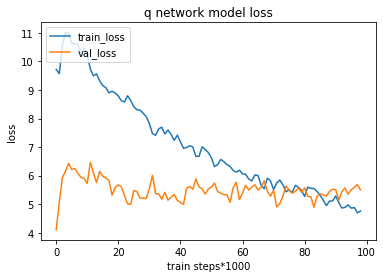

In [23]:
plt.plot(abs_error_list, label = 'train_loss')
plt.plot(val_abserror_list, label = 'val_loss')
plt.title('q network model loss')
plt.ylabel('loss')
plt.xlabel('train steps*1000')
plt.legend(loc='upper left')
plt.show()